<img src="https://avatars.githubusercontent.com/u/74911464?s=200&v=4"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 10px;" />
# OpenEO Platform - UC3
Rule-based crop classification using S1 and S2

In [1]:
import openeo
from openeo.processes import array_modify
from openeo.rest.conversions import timeseries_json_to_pandas
from eo_utils import *
from matplotlib import pyplot as plt
from shapely.geometry import box
import pandas as pd
from helper import *
import geopandas as gpd

c:\users\driesseb\.conda\envs\openeo\lib\site-packages\xarray\backends\cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


## Objectives and approach

The objective of this notebook is to perform an easy rule-based classification for 5 crop types. The notebook has two subsections. 

The first one is oriented towards creating temporal NDVI profiles of a potato field.

The second one is about the actual rule-based classification. To determine these rules, we use harmonized LPIS data of 5 crop types with 10 ground truth samples each. By point sampling per crop type from this dataset, we can load in the S1- and S2 spectral profiles of each of these crop type and make boxplots of the VV/VH ratio as well as the NDVI, a NIR band and a SWIR band. These boxplots will then be used to derive some classification rules manually. Finally, crop classification is done and the results are plotted.

In [2]:
connection = openeo.connect("openeo.cloud")

In [4]:
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeocloud.vito.be/openeo/1.0.0/' with BearerAuth>

## Load the dataset

Connect to the vito backend and load Sentinel-2 bands 4 (RED), 8 (NIR), 11 (SWIR) and the scene classification layer (SCL) for the year of 2019. This last layer will be used for cloud masking. We will not specify a spatial filter for now as a spatial filter will be applied later on.
We will use the scene classification band to perform cloud masking and subsequently drop the SCL layer as we will not need it anymore in the rest of this notebook.

We use a temporal range that is slightly bigger than the actual temporal range we need to improve the interpolation that we will do later on.

In [26]:
year = 2019
temp_ext = [str(year-1)+"-11-01", str(year+1)+"-02-01"]

s2 = connection.load_collection("TERRASCOPE_S2_TOC_V2",                                 
                                temporal_extent=temp_ext,
                                bands=["B04","B08","B11","SCL"])
s2_masked = s2.process("mask_scl_dilation", data=s2, scl_band_name="SCL").filter_bands(["B04", "B08", "B11"])

## Timeseries analysis of vegetation greenness

Different land cover types can be identified by their seasonal greenup / greendown patterns. For example, coniferous forests are green all year round and have little variation in  greenness over time, while crops like sugar beet and maize are characterized by strong seasonal fluctuations. An overview of several crops types is displayed below.

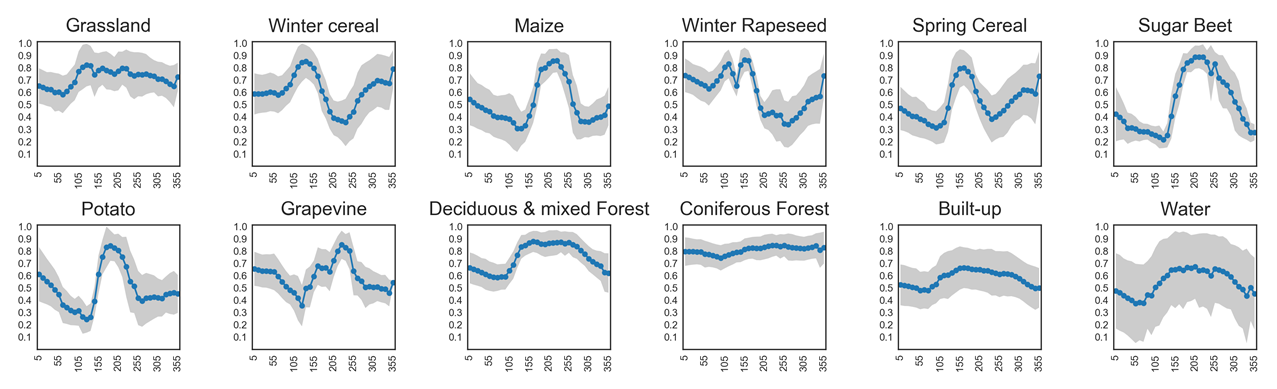

So, first we want to calculate a vegetation index such as the NDVI or the EVI. To do so, we need to define a callback function that can be passed to the process parameter of apply_dimension. This callback function is defined in the compute_indices method which can be found in helper.py

After computing the NDVI, our datacube is holding double precision floating point numbers, at 8 bytes per value. This requires a lot of memory in subsequent steps. That is why we rescale the NDVI values to [0,250], requiring only 1 byte. If you want to have a little more precision (at the cost of lower computational speed), using 2-byte integers would also be an option. This optimization can not be done automatically by openEO, because ultimately this tradeoff between computational speed and accuracy is up to the user and is highly dependent on the use case.

In [28]:
ndvi = compute_indices(s2_masked,["NDVI"],250).filter_bands(["NDVI"])

Next, we temporally aggreate to 10-day averages and apply a spatial filter to a potato field that we preselected. We calculate these averages after calculating the NDVI instead of before to avoid computing an NDVI on unobserved band combinations.

In [6]:
bbox_potatofield = (3.547189, 50.865238, 3.548602, 50.866717)
agg_dekad = ndvi.aggregate_temporal_period(period="dekad", reducer="mean")
ndvi_dekad = agg_dekad.apply_dimension(dimension="t", process="array_interpolate_linear").filter_temporal([str(year)+"-01-01", str(year)+"-12-31"])
ndvi_bbox = ndvi_dekad.filter_spatial(geometries=box(*bbox_potatofield))

This NDVI is calculated for every pixel in every time step t in the masked NIR/red image that we extracted from SentinelHub. Now we want to aggregate all the pixels within the potato field to end up with a timeseries. We do this by calculating the mean over all the pixels as well as the standard deviation, to have an indication of the error. The more homogeneous the input area is (in this case, the potato field, but in theory you could use in any bounding box of choice), the smaller your error will be.

In [7]:
%time timeseries = ndvi_bbox.aggregate_spatial(reducer="mean", geometries=box(*bbox_potatofield)).execute()

CPU times: user 6.7 ms, sys: 2.38 ms, total: 9.09 ms
Wall time: 42.9 s


In [8]:
%time timeseries_sd = ndvi_bbox.aggregate_spatial(reducer="sd", geometries=box(*bbox_potatofield)).execute()

CPU times: user 5.5 ms, sys: 2.42 ms, total: 7.92 ms
Wall time: 41.4 s


Finally, we can plot the mean and standard deviation for the area of choice, and we can compare our output to the image above.

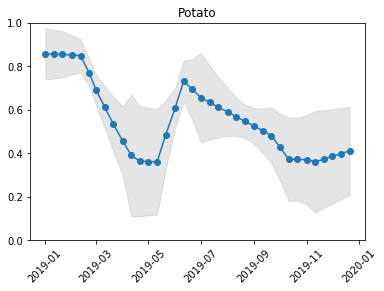

In [9]:
timeser = pd.concat([timeseries_json_to_pandas(timeseries),timeseries_json_to_pandas(timeseries_sd)], axis=1).dropna() / 250
timeser.columns = ["Mean NDVI", "SD"]
timeser.index = pd.to_datetime(timeser.index)
timeser = timeser.sort_index()

plt.plot(timeser["Mean NDVI"],"o-")
plt.fill_between(timeser.index,
                 timeser["Mean NDVI"] - timeser["SD"], 
                 timeser["Mean NDVI"] + timeser["SD"],
                 color='gray', alpha=0.2)
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.title("Potato")
plt.show()

## Creating rules for rule-based classification

In the following section, we will proceed to creating the rules that will be used for classification. These rules will be determined by plotting the spectral profile as well as the NDVI for a number of crops, and these crop locations are known through a reference dataset containing ground truth observations spread over Belgium.

Of course, next to ground truth data, we will need S1 and S2 data. First, we will do some preprocessing on the S2 data. The theoretical maxium of Sentinel-2 band values is 0-10000, however in practice this maximum lies lower; we decided to place this "practical maximum" at 8000. Just like we did before for the NDVI data, we rescale the S2 data to [0,250] for computational efficiency.

After that, we merge the NDVI band with the Sentinel-2 bands, calculate the monthly aggregates and interpolate to impute any months for which no data is available.

In [29]:
s2_scaled = s2_masked.filter_bands(["B08","B11"]).apply_dimension(dimension="bands",process=lambda x: lin_scale_range(x,0,8000,0,250))
ndvi_comp = ndvi.merge_cubes(s2_scaled).rename_labels("bands",ndvi.metadata.band_names + s2_scaled.metadata.band_names)

ndvi_month = ndvi_comp.aggregate_temporal_period(period="month", reducer="mean")
ndvi_month = ndvi_month.apply_dimension(dimension="t", process="array_interpolate_linear")

We will also load in Sentinel-1 data, which will be used in some of the crop rules. We do the same operations as we did for S2 (temporal aggregation, imputation), and additionally we resample it to the spatial resolution of the Sentinel-2 composite.

In [30]:
s1 = connection.load_collection("S1_GRD_SIGMA0_ASCENDING",                                 
                                temporal_extent=temp_ext,
                                bands=["VH","VV"]
                               )

composite_s1 = s1.apply_dimension(dimension="bands",process=lambda x: array_modify(data=x, values=x.array_element(0)/x.array_element(1), index=0))
composite_s1 = composite_s1.apply_dimension(dimension="bands", process=lambda x: lin_scale_range(x,0,1,0,250))

s1_month = composite_s1.aggregate_temporal_period(period="month", reducer="mean")
s1_month = s1_month.apply_dimension(dimension="t", process="array_interpolate_linear")
s1_month = s1_month.resample_cube_spatial(ndvi_comp)

Finally, we merge the NDVI & Sentinel-2 composite with the Sentinel-1 data.

In [31]:
ndvi_comp_sar = ndvi_month.merge_cubes(s1_month).rename_labels("bands",ndvi_month.metadata.band_names + ["ratio","VV","VH"]).filter_bands(ndvi_month.metadata.band_names+["ratio"]).filter_temporal([str(year)+"-01-01", str(year)+"-12-31"])

### Reference dataset

For this use case, we use harmonized LPIS data from the ESA WorldCereal project. The following crop types are of interest, with their code in the legend:
- **maize: 1200**
- winter wheat: 1110
- spring wheat: 1120
- **barley: 1500** (winter barley: 1510, spring barley: 1520)
- **potatos: 5100**
- **sugar beet: 8100**
- rapeseed: 4350 (winter rapeseed: 4351, spring rapeseed: 4352)
- sunflower: 4380
- **soy bean: 4100**

For this project, we will focus on the five crop types delineated in bold: maize (corn), potato, sugarbeet, barley and soy. For each of these crop types, we randomly selected 10 fields (polygons).

In [10]:
crops = {"maize":1200,"potatos":5100,"sugarbeet":8100,"barley":1500,"soy":4100}
crop_samples = {name:gpd.read_file("UC3_resources/"+ name + "_2019.geojson", driver='GeoJSON') for name,code in crops.items()}

### Retrieve timeseries

Next we want to point sample the monthly aggregates of NDVI, VNIR-SWIR and SAR from the fields defined in crop_samples. These will give us an indication of the temporal profile of different products of different crops, which we will then use to formulate the crop calendar rules.
From the LPIS data, we selected 10 fields per crop type, and in total we sample 30 times per field to end up with a total of 300 samples per crop type.

We have added the 1500 training samples to the github repo to speed up running through this notebook. Running this cell is therefore optional.

In [ ]:
### Note: Running this cell is optional!

points_per_type = point_sample_fields(crop_samples, 30)

job_options = {
                "driver-memory": "2G",
                "driver-memoryOverhead": "1G",
                "driver-cores": "2",
                "executor-memory": "5G",
                "executor-memoryOverhead": "5G",
                "executor-cores": "1",
                "max-executors": "100"
                }

for i in points_per_type.keys():
    sampled_features = ndvi_comp_sar.filter_spatial(eval(points_per_type[i]))
    job = sampled_features.execute_batch(
        title="Point feature extraction",
        description="Feature extraction for S1 and S2 data and derived products",
        out_format="netCDF",
        sample_by_feature=True,
        job_options=job_options)
    results = job.get_results()
    results.download_files("./data/300_"+i)

And finally, we want to visualise the results by creating boxplots

In [4]:
%time df = prep_boxplot(2019,["B08", "B11", "NDVI", "ratio"])

Wall time: 58.4 s


Wall time: 5.64 s


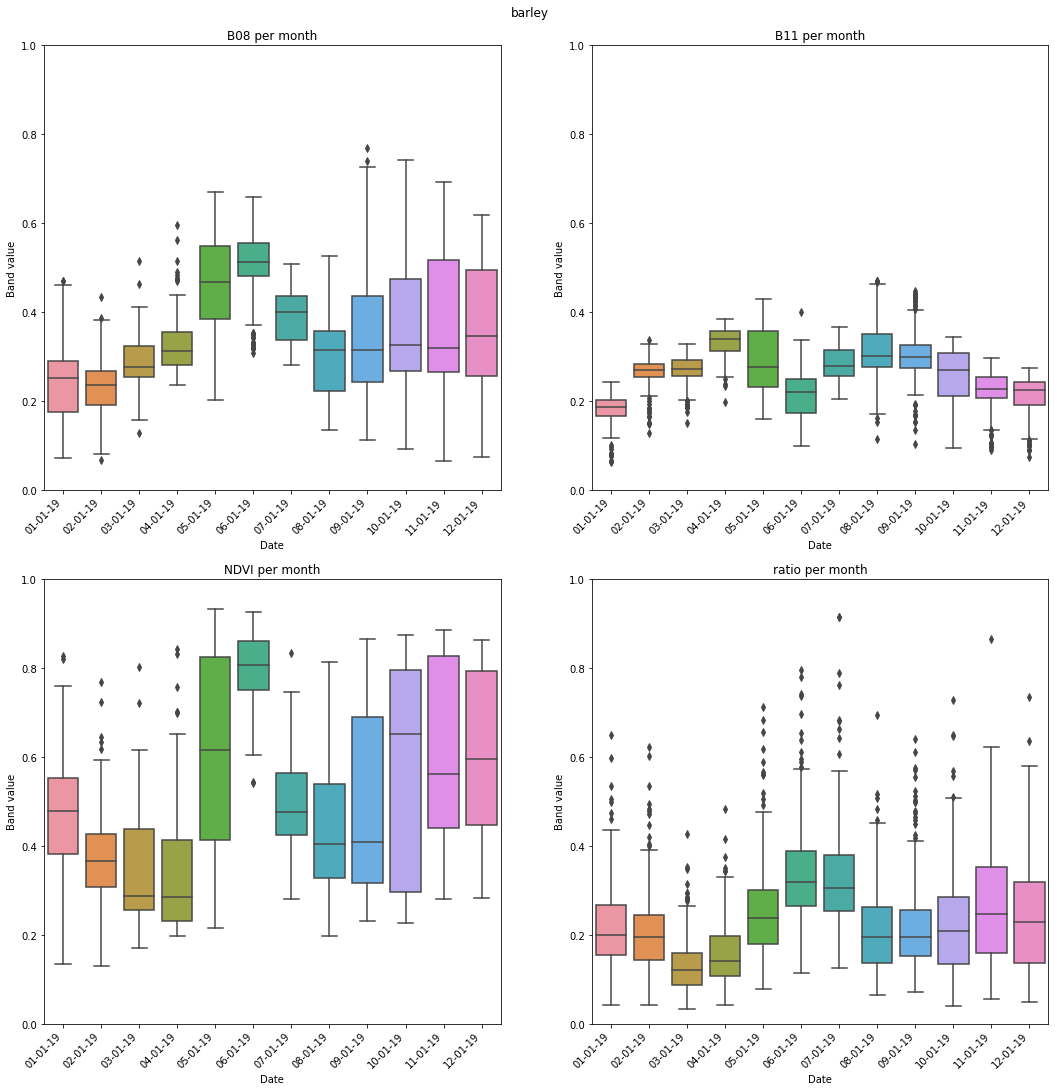

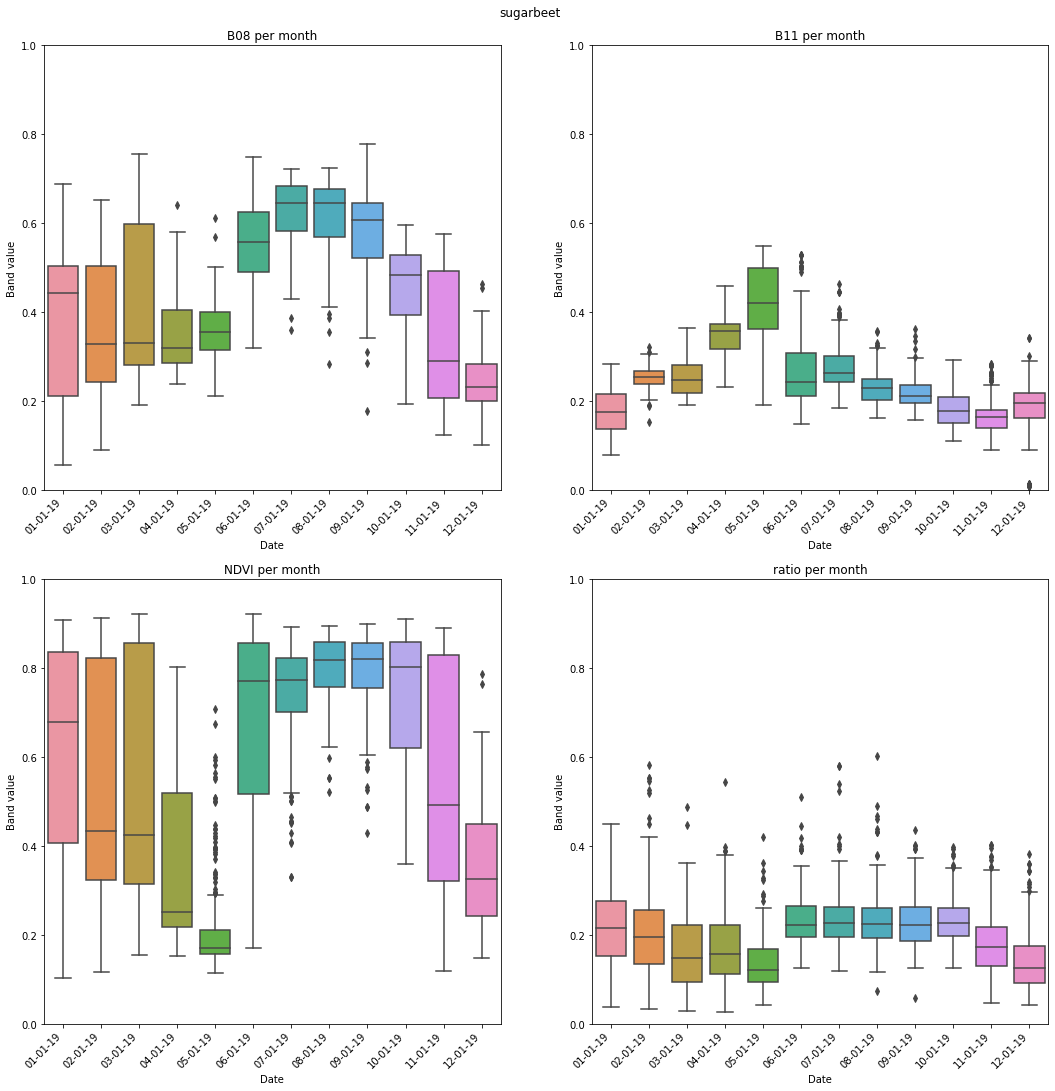

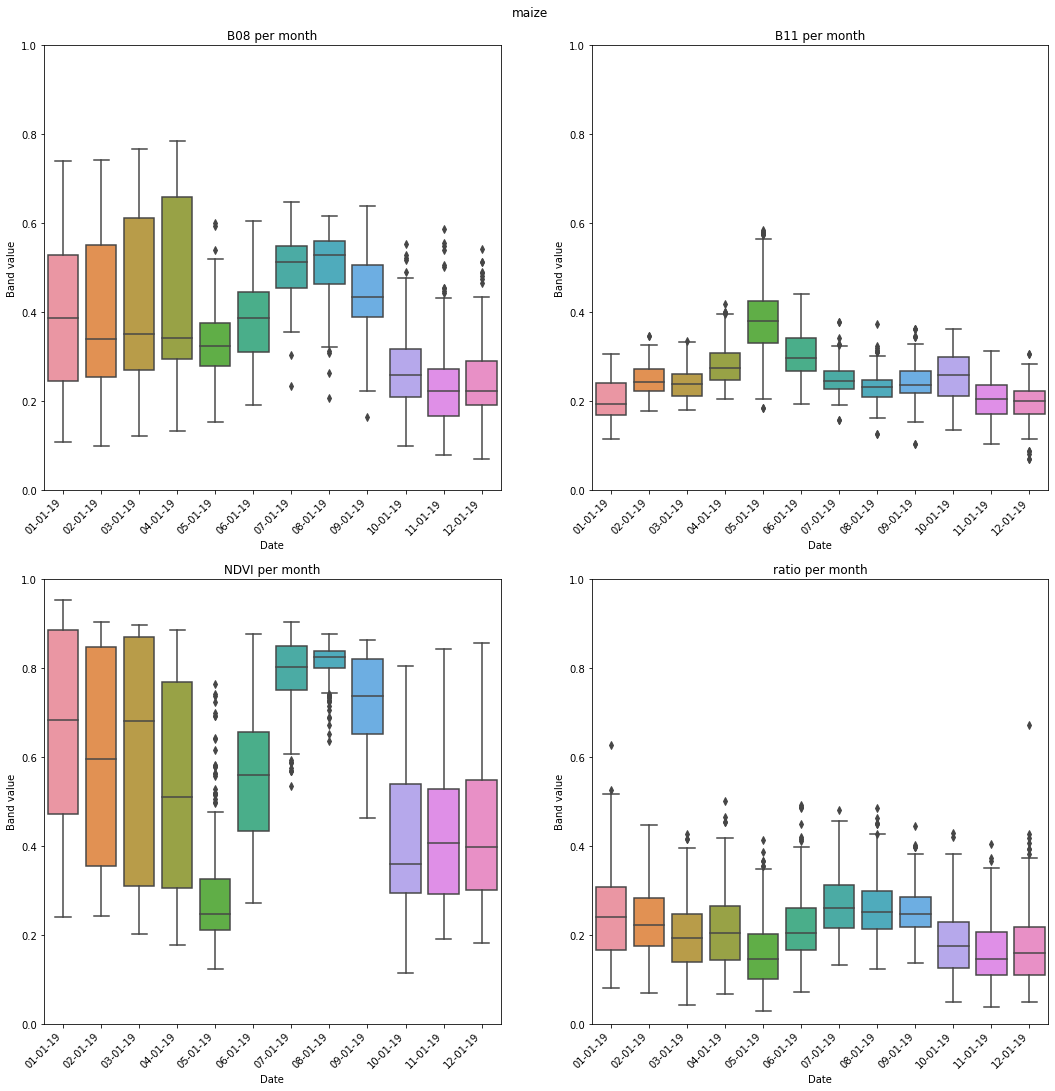

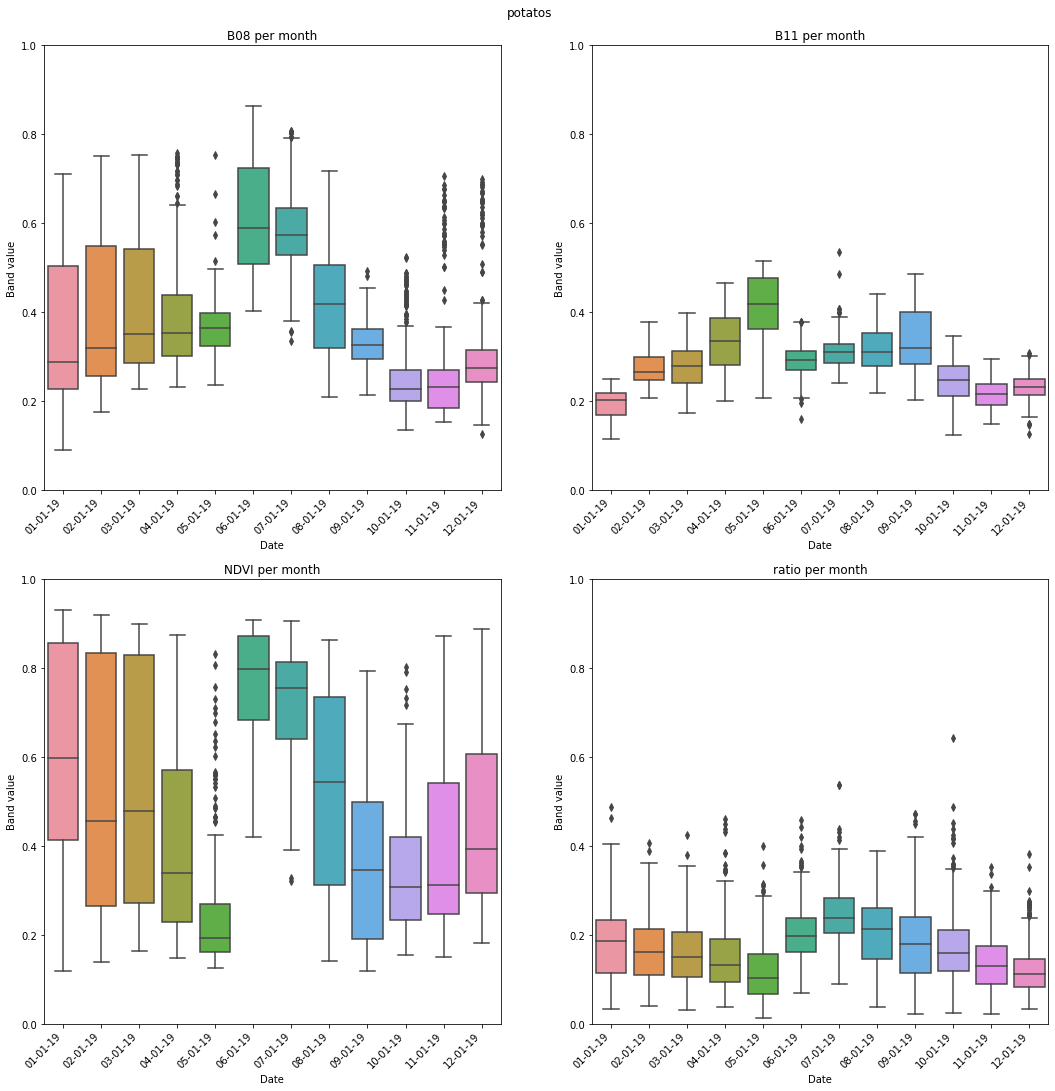

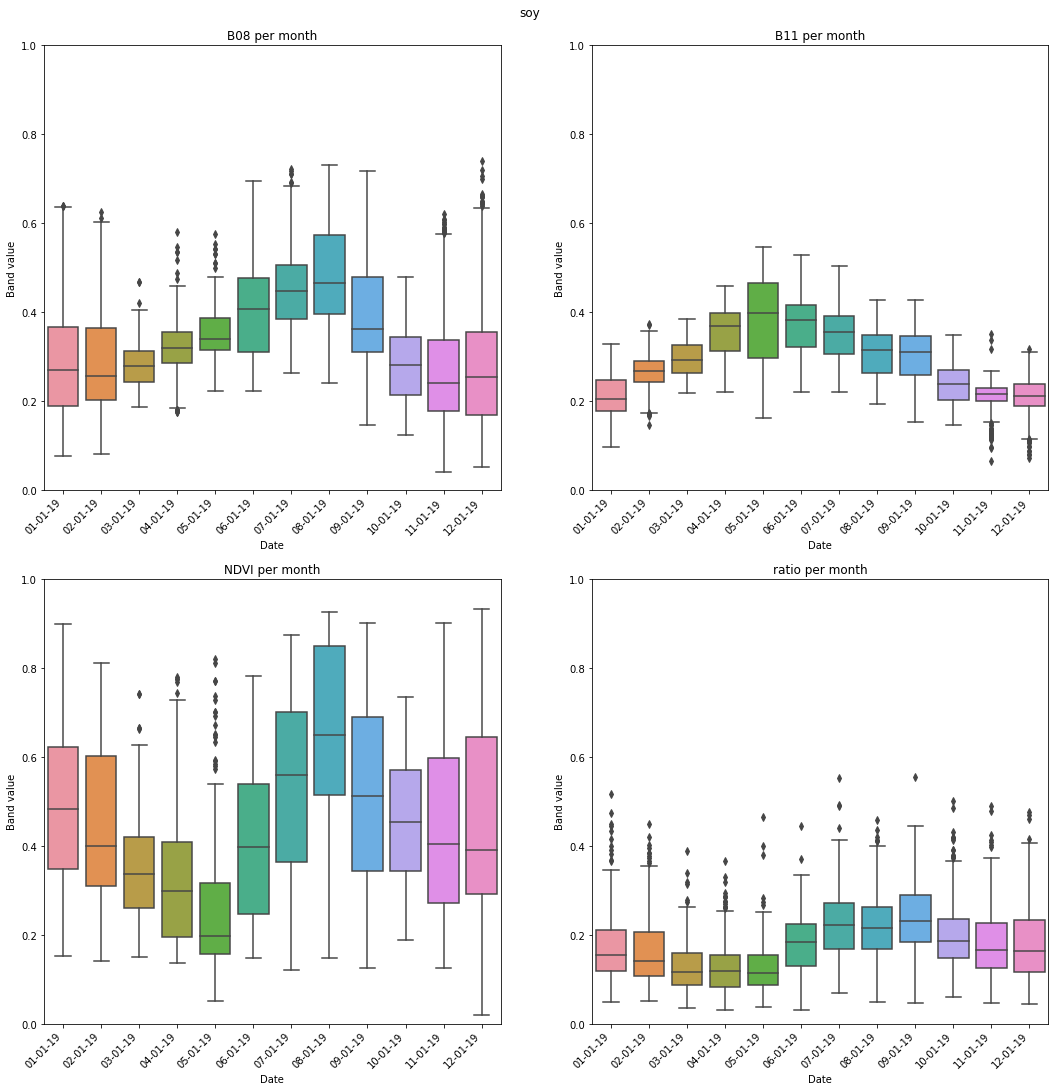

In [5]:
%time create_boxplots(df)

## Rule based stratification

Now it is time to put the rules we visually determined into practice. First, determine whether you want to use SAR bands in your rules.

In [24]:
run_with_SAR = False

We will prepare the datacube by melting the temporal dimension into the band dimension. This way, we end up with a band for every product for every month. We have two options here:
- deal with the rescaled band values (lambda x: x * 1), which has a slight computational benefit, or 
- transform them back to their original range of floating values by dividing by 250 (lambda x: x/250) (1 run without SAR: +/- 14 minutes).

Of course, the rules will need to be adjusted to the range of choice as well.

In [32]:
all_bands = ndvi_comp_sar.apply_dimension(dimension='t', target_dimension='bands', process=lambda x: x*1)
bandnames = [band + "_" + stat for band in all_bands.metadata.band_names for stat in ["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]]
all_bands = all_bands.rename_labels('bands', target=bandnames)

We have defined so called 'expert rules' based on crop calendars and an analysis of time series profiles (the boxplots shown above), to classify a crop type based on temporal behaviour.

The rules in this notebook have not been validated, and were mostly verified in Belgium. Crop calendar based rules are region depended, and can even change over time for the same region.

In [33]:
ndvi_jan = all_bands.band("NDVI_jan")
ndvi_apr = all_bands.band("NDVI_apr")
ndvi_may = all_bands.band("NDVI_may")
ndvi_jun = all_bands.band("NDVI_jun")
ndvi_jul = all_bands.band("NDVI_jul")
ndvi_aug = all_bands.band("NDVI_aug")
ndvi_sep = all_bands.band("NDVI_sep")
ndvi_oct = all_bands.band("NDVI_oct")
ndvi_nov = all_bands.band("NDVI_nov")

nir_mar = all_bands.band("B08_mar")
nir_may = all_bands.band("B08_may")
nir_jun = all_bands.band("B08_jun")
nir_oct = all_bands.band("B08_oct")
swir_mar = all_bands.band("B11_mar")
swir_apr = all_bands.band("B11_apr")
swir_may = all_bands.band("B11_may")
swir_oct = all_bands.band("B11_oct")

corn = (((ndvi_may < ndvi_jun) + (ndvi_sep > ndvi_nov) + (((ndvi_jul+ndvi_aug+ndvi_sep)/3) > 175)) == 3)*1
barley = (((ndvi_apr < ndvi_may) + ((ndvi_jun / ndvi_jul)>1.4) + (swir_apr > swir_may)) == 2)*1
sugarbeet = (((ndvi_may < 0.6*ndvi_jun) + ((ndvi_jun+ndvi_jul+ndvi_aug+ndvi_sep+ndvi_oct)/5 > 175))==2)*1
potato = ((((ndvi_jun/ndvi_may) > 2) + (ndvi_sep < ndvi_jul) + (ndvi_jan > ndvi_oct) + ((swir_may / nir_may) > 0.8) + ((nir_jun / nir_may) > 1.4)) == 5)*1
soy = (((ndvi_apr > ndvi_may) + (ndvi_sep < ndvi_aug) + ((nir_oct / swir_oct) > 1)) == 4)*1

if run_with_SAR:
    apr_rat = all_bands.band("ratio_apr")
    may_rat = all_bands.band("ratio_may")
    jun_rat = all_bands.band("ratio_jun")
    jul_rat = all_bands.band("ratio_jul")
    aug_rat = all_bands.band("ratio_aug")
    sep_rat = all_bands.band("ratio_sep")
    oct_rat = all_bands.band("ratio_oct")
    corn = (corn + ((jul_rat + aug_rat) > (jun_rat + oct_rat)) == 2)
    potato = (potato + ((jun_rat + aug_rat)/2 < jul_rat) == 2)
    sugarbeet = (sugarbeet + (sep_rat > may_rat) + (oct_rat > may_rat) == 3)
    barley = (barley + (jun_rat > aug_rat) + (jun_rat > apr_rat) == 3)
    soy = (soy + (jun_rat > apr_rat) + (jun_rat > may_rat) == 3)

Finally, we combine all of these crop rules by using a geometric progression using the successive powers of two, enabling us to plot all possible combinations in one plot.

In [34]:
total = (1*corn + 2*barley + 4*sugarbeet + 8*potato + 16*soy).linear_scale_range(0,32,0,32)

Select a polygon on the map below to test the rule-based model. For the sake of the analysis, make sure you select a region that is in Belgium or surroundings, as the rules were optimized for that region specifically.

In [35]:
center = [50.8, 4.75]
zoom = 13

eoMap = openeoMap(center,zoom)
addS2Tiles(eoMap)
eoMap.map

Map(center=[50.8, 4.75], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…

In [36]:
bbox = eoMap.getBbox()

In [ ]:
job_options={
    "driver-memory": "2G",
    "driver-memoryOverhead": "1G",
    "driver-cores": "2",
    "executor-memory": "2G",
    "executor-memoryOverhead": "1G",
    "executor-cores": "3",   
    "max-executors": "100"
}
job = total.filter_bbox({'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3]}).execute_batch(
    out_format="GTiff",
    colormap=get_classification_colors(),
    title="Rule-based crop classification",
    description="Rule-based crop classification for 5 crops (soy, barley, corn, sugarbeet and potato) using only S2 data and a S2-derived product (NDVI)",
    job_options=job_options)
results = job.get_results()
results.download_file("./data/total.tif")

0:00:00 Job 'vito-bdf324a6-b2f2-43ad-af43-c1010cc041b7': send 'start'


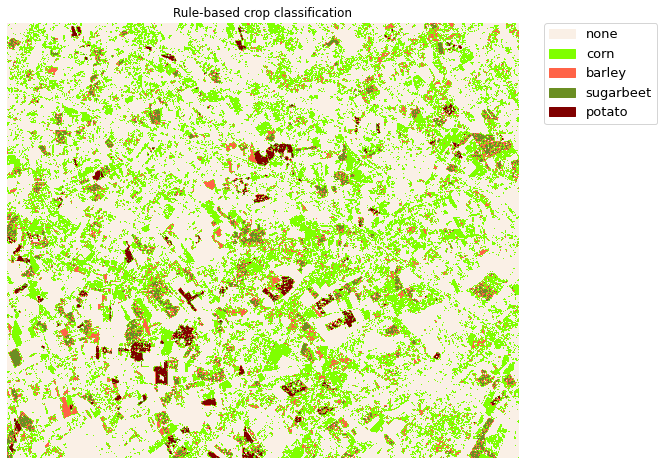

In [15]:
plot_croptypes(fn="./data/total.tif", only_unique_classes=True)

In [18]:
connection.list_jobs()

[{'created': '2021-09-07T18:27:45Z',
  'id': 'vito-f877156e-5934-4de9-baaa-63c29ba33788',
  'status': 'finished',
  'updated': '2021-09-07T18:28:57Z'},
 {'created': '2021-09-08T07:50:56Z',
  'id': 'vito-14d72abe-8fe2-4cff-9aa6-f32712df6126',
  'status': 'error',
  'updated': '2021-09-08T07:51:37Z'},
 {'created': '2021-09-08T07:57:13Z',
  'id': 'vito-fb34a9ee-8fb3-45a5-a132-340b3a377836',
  'status': 'finished',
  'updated': '2021-09-08T07:57:48Z'},
 {'created': '2021-09-08T07:40:16Z',
  'id': 'vito-0c07b574-05fc-4c09-a9f1-6c4e9003dcde',
  'status': 'finished',
  'updated': '2021-09-08T07:40:50Z'},
 {'created': '2021-09-15T11:10:18Z',
  'description': 'Feature extraction for S1 and S2 data and derived products',
  'id': 'vito-d1b5924c-939e-4429-ac7e-a49200dc4798',
  'status': 'finished',
  'title': 'Point feature extraction',
  'updated': '2021-09-15T11:10:58Z'},
 {'created': '2021-09-15T13:36:40Z',
  'description': 'Rule-based crop classification for 5 crops (soy, barley, corn, sugarbeet and potato) using only S2 data and a S2-derived product (NDVI)',
  'id': 'vito-140560b3-a05d-4bd3-b339-a19de0a48e0c',
  'status': 'finished',
  'title': 'Rule-based crop classification',
  'updated': '2021-09-15T13:38:48Z'},
 {'created': '2021-09-15T09:40:07Z',
  'description': 'Feature extraction for S1 and S2 data and derived products',
  'id': 'vito-20cfa473-35ee-46a2-bb06-12d9ab4cc9b9',
  'status': 'finished',
  'title': 'Point feature extraction',
  'updated': '2021-09-15T09:42:01Z'},
 {'created': '2021-09-10T06:43:31Z',
  'description': 'Rule-based crop classification for 5 crops (soy, barley, corn, sugarbeet and potato) using only S2 data and a S2-derived product (NDVI)',
  'id': 'vito-1dda267e-ef04-483d-81cc-6bf33a212b67',
  'status': 'finished',
  'title': 'Rule-based crop classification',
  'updated': '2021-09-10T06:44:09Z'},
 {'created': '2021-09-15T12:44:06Z',
  'description': 'Feature extraction for S1 and S2 data and derived products',
  'id': 'vito-6d559037-e18a-4535-9aa6-55812f571463',
  'status': 'finished',
  'title': 'Point feature extraction',
  'updated': '2021-09-15T12:45:34Z'},
 {'created': '2021-09-08T08:24:39Z',
  'id': 'vito-fe43c59c-5b54-495a-820c-ea2a87f42994',
  'status': 'finished',
  'updated': '2021-09-08T08:27:12Z'},
 {'created': '2021-09-09T11:50:45Z',
  'description': 'Rule-based crop classification for 5 crops (soy, barley, corn, sugarbeet and potato) using only S2 data and a S2-derived product (NDVI)',
  'id': 'vito-932aded8-beb1-4c9c-83f3-1375588e8091',
  'status': 'finished',
  'title': 'Rule-based crop classification',
  'updated': '2021-09-09T11:52:10Z'},
 {'created': '2021-09-07T15:17:07Z',
  'id': 'vito-2e435f71-c8c5-4ffc-9c38-b093fbf1877a',
  'status': 'finished',
  'updated': '2021-09-07T15:17:44Z'},
 {'created': '2021-09-07T13:48:23Z',
  'id': 'vito-60b66af7-3ce4-4c40-be2d-5889d360b41a',
  'status': 'finished',
  'updated': '2021-09-07T13:49:06Z'},
 {'created': '2021-09-08T10:24:01Z',
  'id': 'vito-f6587109-cf98-42db-9552-7fba78d200a4',
  'status': 'finished',
  'updated': '2021-09-08T10:24:42Z'},
 {'created': '2021-09-08T08:07:48Z',
  'id': 'vito-1d784d40-e2a9-4379-afcf-6698d5953cb0',
  'status': 'finished',
  'updated': '2021-09-08T08:08:27Z'},
 {'created': '2021-09-08T09:47:47Z',
  'id': 'vito-47394540-c78e-4ed0-b319-e39f6d652421',
  'status': 'finished',
  'updated': '2021-09-08T09:48:19Z'},
 {'created': '2021-09-15T09:08:50Z',
  'description': 'Feature extraction for S1 and S2 data and derived products',
  'id': 'vito-09fef4f7-f659-4651-ac42-a725e3b0729e',
  'status': 'finished',
  'title': 'Point feature extraction',
  'updated': '2021-09-15T09:09:31Z'},
 {'created': '2021-09-15T10:35:07Z',
  'description': 'Feature extraction for S1 and S2 data and derived products',
  'id': 'vito-fe63bfba-5538-4339-b17a-04d02ba683cd',
  'status': 'finished',
  'title': 'Point feature extraction',
  'updated': '2021-09-15T10:36:19Z'},
 {'created': '2021-09-09T11:18:33Z',
  'id': 'vito-aa8c051c-f0f5-49dd-b181

<img src="https://artifactory.vgt.vito.be:443/auxdata-public/openeo/signed_url.gif">

In [29]:
def computeStats(input_timeseries:ProcessBuilder):
    return input_timeseries.quantiles(probabilities=[0.1,0.5,0.9])

features = ndvi.apply_dimension(dimension='t',target_dimension='bands', process=computeStats)
features = features.rename_labels('bands',[band + "_" + stat for band in ndvi.metadata.band_names for stat in ["p10","p50","p90"]])

job_feat = features.filter_bbox({'west':bbox_potatofield[0],'east':bbox_potatofield[2],'south':bbox_potatofield[1],'north':bbox_potatofield[3]}).execute_batch(
    out_format="netCDF",
    title="Extra feature (quantiles)",
    description="Calculating quantiles for a small potato field",
    job_options=job_options)
results_feat = job_feat.get_results()
results_feat.download_file("./data/indices.nc")

0:00:00 Job 'a46af33e-a589-487f-ada0-6a4a89f00aee': send 'start'
0:00:48 Job 'a46af33e-a589-487f-ada0-6a4a89f00aee': queued (progress N/A)
0:00:53 Job 'a46af33e-a589-487f-ada0-6a4a89f00aee': queued (progress N/A)
0:01:00 Job 'a46af33e-a589-487f-ada0-6a4a89f00aee': queued (progress N/A)
0:01:09 Job 'a46af33e-a589-487f-ada0-6a4a89f00aee': queued (progress N/A)
0:01:19 Job 'a46af33e-a589-487f-ada0-6a4a89f00aee': queued (progress N/A)
0:01:33 Job 'a46af33e-a589-487f-ada0-6a4a89f00aee': queued (progress N/A)
0:01:49 Job 'a46af33e-a589-487f-ada0-6a4a89f00aee': queued (progress N/A)
0:02:09 Job 'a46af33e-a589-487f-ada0-6a4a89f00aee': queued (progress N/A)
0:02:33 Job 'a46af33e-a589-487f-ada0-6a4a89f00aee': queued (progress N/A)
0:03:04 Job 'a46af33e-a589-487f-ada0-6a4a89f00aee': queued (progress N/A)
0:03:42 Job 'a46af33e-a589-487f-ada0-6a4a89f00aee': queued (progress N/A)
0:04:29 Job 'a46af33e-a589-487f-ada0-6a4a89f00aee': running (progress N/A)
0:05:29 Job 'a46af33e-a589-487f-ada0-6a4a89f00

WindowsPath('data/indices.nc')